In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

data_dir = "/kaggle/input/indian-sign-language-isl/Indian"
EPOCHS = 30

2025-07-29 06:00:34.232246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753768834.501312      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753768834.583849      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def preprocess_image(image, target_size=(256, 256)):
    if image is None or image.size == 0:
        print("Warning: Invalid image encountered")
        return None
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if image.shape != target_size:
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=-1)  
    return image

In [3]:
def build_model(input_shape=(256, 256, 1), num_classes=35):
    model = Sequential([
        Conv2D(24, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2), strides=2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Dropout(0.3),
        MaxPooling2D((2, 2), strides=2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Dropout(0.3),
        MaxPooling2D((2, 2), strides=2),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Dropout(0.3),
        MaxPooling2D((2, 2), strides=2),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Dropout(0.3),
        MaxPooling2D((2, 2), strides=2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [4]:
def load_and_balance_data(data_dir):
    image_paths = []
    labels = []
    expected_classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9'] + [chr(i) for i in range(65, 91)]  
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        class_images = [f for f in os.listdir(class_dir)]
        print(f"Class '{class_name}': {len(class_images)} images")
        for img_name in class_images:
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_name)
    
    print(f"Loaded {len(image_paths)} images across {len(set(labels))} classes")
    if len(image_paths) == 0:
        raise ValueError("No images loaded. Check dataset path and structure.")
    if len(set(labels)) != 35:
        print(f"Warning: Expected 35 classes, found {len(set(labels))} classes")
    data = pd.DataFrame({'JPG': image_paths, 'CATEGORY': labels})
    return data

In [5]:
main_data = load_and_balance_data(data_dir)
main_data = main_data.sample(frac=1).reset_index(drop=True) 
num_classes = len(set(main_data['CATEGORY']))
print(f"Number of classes: {num_classes}")

X_train, X_test = train_test_split(main_data, train_size=0.9, random_state=41, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Class 'N': 1200 images
Class '7': 1200 images
Class 'R': 1200 images
Class '2': 1200 images
Class 'B': 1200 images
Class 'I': 1379 images
Class 'F': 1200 images
Class 'H': 1200 images
Class '5': 1200 images
Class 'E': 1200 images
Class 'U': 1200 images
Class 'M': 1200 images
Class '8': 1200 images
Class 'X': 1200 images
Class 'K': 1200 images
Class 'Q': 1200 images
Class 'Y': 1200 images
Class 'S': 1200 images
Class 'G': 1200 images
Class 'A': 1200 images
Class 'O': 1429 images
Class 'T': 1200 images
Class 'V': 1290 images
Class 'Z': 1200 images
Class '3': 1200 images
Class '1': 1200 images
Class 'C': 1447 images
Class '4': 1200 images
Class 'P': 1200 images
Class '9': 1200 images
Class 'L': 1200 images
Class '6': 1200 images
Class 'W': 1200 images
Class 'D': 1200 images
Class 'J': 1200 images
Loaded 42745 images across 35 classes
Number of classes: 35
Train shape: (38470, 2), Test shape: (4275, 2)


In [6]:
train_img_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.5,
    shear_range=0.5,
    brightness_range=[0.6, 1.0],
    rotation_range=35,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True,
    fill_mode="nearest",
    validation_split=0.1
)
test_img_generator = ImageDataGenerator(rescale=1./255)

train_set = train_img_generator.flow_from_dataframe(
    dataframe=X_train,
    x_col="JPG",
    y_col="CATEGORY",
    batch_size=32,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training",
    target_size=(256, 256)
)
validation_set = train_img_generator.flow_from_dataframe(
    dataframe=X_train,
    x_col="JPG",
    y_col="CATEGORY",
    batch_size=32,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation",
    target_size=(256, 256)
)
test_set = test_img_generator.flow_from_dataframe(
    dataframe=X_test,
    x_col="JPG",
    y_col="CATEGORY",
    batch_size=32,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=False,
    target_size=(256, 256)
)

print("Train class indices:", train_set.class_indices)
print("Validation class indices:", validation_set.class_indices)
print("Test class indices:", test_set.class_indices)

Found 34623 validated image filenames belonging to 35 classes.
Found 3847 validated image filenames belonging to 35 classes.
Found 4275 validated image filenames belonging to 35 classes.
Train class indices: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'I': 17, 'J': 18, 'K': 19, 'L': 20, 'M': 21, 'N': 22, 'O': 23, 'P': 24, 'Q': 25, 'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 'Z': 34}
Validation class indices: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'I': 17, 'J': 18, 'K': 19, 'L': 20, 'M': 21, 'N': 22, 'O': 23, 'P': 24, 'Q': 25, 'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 'Z': 34}
Test class indices: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15,

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 24)   │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,771,315 (18.20 MB)

 Trainable params: 4,771,267 (18.20 MB)

 Non-trainable params: 48 (192.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1753769065.292588      99 service.cc:148] XLA service 0x7854d8012a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753769065.293812      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753769065.293831      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753769065.829541      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1082 ━━━━━━━━━━━━━━━━━━━━ 1:29 83ms/step - accuracy: 0.0312 - loss: 4.6642  

I0000 00:00:1753769074.775309      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.3614 - loss: 2.2646
Epoch 1: val_accuracy improved from -inf to 0.92124, saving model to signlangtask7.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 471s 422ms/step - accuracy: 0.3616 - loss: 2.2637 - val_accuracy: 0.9212 - val_loss: 0.7341 - learning_rate: 0.0010
Epoch 2/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8659 - loss: 0.3990
Epoch 2: val_accuracy improved from 0.92124 to 0.95243, saving model to signlangtask7.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 238s 220ms/step - accuracy: 0.8659 - loss: 0.3990 - val_accuracy: 0.9524 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 3/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9190 - loss: 0.2409
Epoch 3: val_accuracy did not improve from 0.95243
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 236s 218ms/step - accuracy: 0.9190 - loss: 0.2409 - val_accuracy: 0.9478 - val_loss: 0.2733 - learning_rate: 0.0010
Epoch 4/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - 

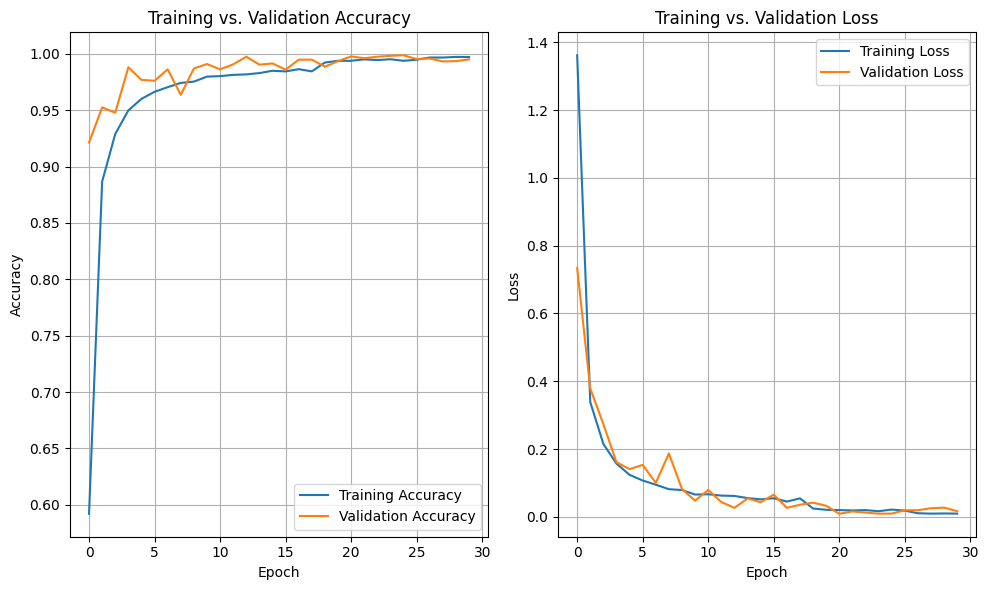

134/134 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - accuracy: 0.9978 - loss: 0.0058
Test Loss: 0.0049
Test Accuracy: 1.00


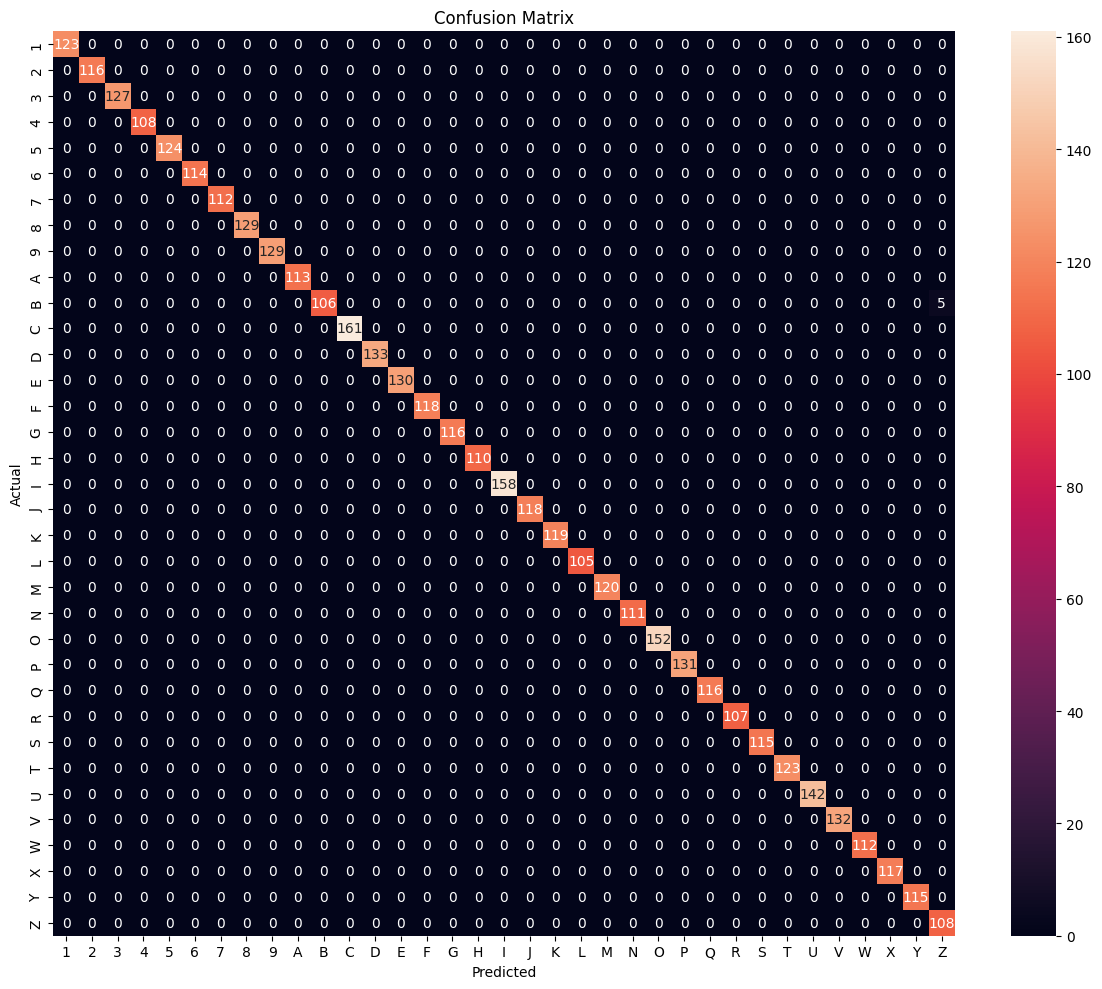


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       123
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00       127
           4       1.00      1.00      1.00       108
           5       1.00      1.00      1.00       124
           6       1.00      1.00      1.00       114
           7       1.00      1.00      1.00       112
           8       1.00      1.00      1.00       129
           9       1.00      1.00      1.00       129
           A       1.00      1.00      1.00       113
           B       1.00      0.95      0.98       111
           C       1.00      1.00      1.00       161
           D       1.00      1.00      1.00       133
           E       1.00      1.00      1.00       130
           F       1.00      1.00      1.00       118
           G       1.00      1.00      1.00       116
           H       1.00      1.00      1.00       110
   

In [8]:
model = build_model(num_classes=num_classes)
checkpoint = ModelCheckpoint(
    filepath='signlangtask7.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

model.load_weights("signlangtask7.weights.h5")
model.save('signlan_task7.h5')
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_mae = history.history['accuracy'][-1]
final_val_mae = history.history['val_accuracy'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_mae:.4f}")
print(f"Final Validation Accuracy: {final_val_mae:.4f}")

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

model_results = model.evaluate(test_set, verbose=1)
print(f"Test Loss: {model_results[0]:.4f}")
print(f"Test Accuracy: {model_results[1]:.2f}")

predictions = model.predict(test_set, verbose=0)
y_pred = np.argmax(predictions, axis=-1)
y_true = test_set.classes

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_set.class_indices.keys(), zero_division=0))